<a href="https://colab.research.google.com/github/fqdna27/Skintone/blob/main/Skintone1211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Develop a skin tone classification model using image data from the 'skintone' directory, preprocess, augment, and split the data, then define and train a CNN model. Evaluate the model's performance, and finally convert the trained model to TensorFlow Lite format while exporting the class labels to a .txt file.

## Setup and Load Data

### Subtask:
Set up the environment by importing necessary libraries and define the dataset directory. Load the image data from the 'skintone' folder, automatically inferring class names from the subfolder structure ('light', 'medium light', 'medium dark', 'dark'), and create a TensorFlow Dataset for efficient data handling.


**Reasoning**:
First, import the necessary libraries, define the dataset directory, and then load the image data into a TensorFlow Dataset.



In [1]:
import tensorflow as tf

# Define the path to the dataset directory
data_dir = 'skintone'

# Create a TensorFlow Dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    image_size=(256, 256),
    batch_size=32
)

# Print the class names to verify
print("Class names:", dataset.class_names)

Found 5386 files belonging to 4 classes.
Class names: ['dark', 'light', 'medium_dark', 'medium_light']


## Preprocess and Split Data

### Subtask:
Preprocess the loaded images by resizing them to a uniform dimension and normalizing pixel values. Split the dataset into training, validation, and test sets. Apply data augmentation techniques (e.g., random flips, rotations) to the training set to enhance model robustness and generalization.


**Reasoning**:
The first step is to define a preprocessing function to normalize image pixel values from [0, 255] to [0, 1] and apply it to the entire dataset. This is crucial for neural network training as it helps with convergence and performance.



In [2]:
def preprocess_image(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label

# Apply the preprocessing function to the entire dataset
preprocessed_dataset = dataset.map(preprocess_image)

print("Dataset preprocessed: images normalized to [0, 1].")

Dataset preprocessed: images normalized to [0, 1].


**Reasoning**:
Now that the dataset is preprocessed, the next step is to split it into training, validation, and test sets. I will calculate the number of batches for each split (80% training, 10% validation, 10% test) and then use `take()` and `skip()` to create the respective datasets.



In [3]:
dataset_size = preprocessed_dataset.cardinality().numpy()

train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_ds = preprocessed_dataset.take(train_size)
val_ds = preprocessed_dataset.skip(train_size).take(val_size)
test_ds = preprocessed_dataset.skip(train_size + val_size).take(test_size)

print(f"Dataset split into: {train_size} training batches, {val_size} validation batches, {test_size} test batches.")

Dataset split into: 135 training batches, 16 validation batches, 18 test batches.


**Reasoning**:
Now that the dataset is split, I will create a data augmentation pipeline and apply it to the training dataset to enhance model robustness. Afterward, I will optimize the performance of all datasets (training, validation, and test) by caching and prefetching them, and also shuffle the training dataset for better generalization.



In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

def apply_augmentation(image, label):
    return data_augmentation(image, training=True), label

# Apply data augmentation only to the training set
train_ds = train_ds.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize performance
train_ds = train_ds.cache().shuffle(buffer_size=1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Data augmentation applied to training dataset.")
print("Datasets cached, shuffled (training only), and prefetched for optimized performance.")

Data augmentation applied to training dataset.
Datasets cached, shuffled (training only), and prefetched for optimized performance.


## Define and Train Model

### Subtask:
Define a Convolutional Neural Network (CNN) model architecture suitable for image classification using TensorFlow Keras. Compile the model with an appropriate optimizer, loss function (e.g., SparseCategoricalCrossentropy), and metrics (e.g., accuracy). Train the model using the preprocessed and augmented training data, with validation on the validation set.


#### Reasoning:
Now, I will define the CNN model architecture. The model will consist of multiple `Conv2D` and `MaxPooling2D` layers to extract features, followed by a `Flatten` layer to convert the 2D feature maps into a 1D vector, and finally, `Dense` layers for classification. After defining the architecture, I will compile the model using the Adam optimizer, `SparseCategoricalCrossentropy` loss function, and `accuracy` as a metric.

**Reasoning**:
Now, I will define the CNN model architecture using `tf.keras.Sequential` and compile it with the specified optimizer, loss function, and metrics.



In [5]:
num_classes = len(dataset.class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

print("CNN model defined and compiled successfully.")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN model defined and compiled successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,492 (56.61 MB)

 Trainable params: 14,839,492 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Now that the model is defined and compiled, I will proceed to train it using the prepared training and validation datasets. I will also incorporate an early stopping callback to prevent overfitting and save computational resources.



In [6]:
epochs = 15 # You can adjust this number

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping]
)

print("Model training complete.")

Epoch 1/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 622s 4s/step - accuracy: 0.4360 - loss: 1.5658 - val_accuracy: 0.5234 - val_loss: 1.1344
Epoch 2/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 548s 4s/step - accuracy: 0.6414 - loss: 0.7792 - val_accuracy: 0.6387 - val_loss: 0.8075
Epoch 3/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 548s 4s/step - accuracy: 0.7128 - loss: 0.6814 - val_accuracy: 0.6387 - val_loss: 0.9799
Epoch 4/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 542s 4s/step - accuracy: 0.7826 - loss: 0.5316 - val_accuracy: 0.5742 - val_loss: 1.2246
Epoch 5/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - accuracy: 0.8098 - loss: 0.4590 - val_accuracy: 0.6406 - val_loss: 1.2017
Epoch 6/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 542s 4s/step - accuracy: 0.8895 - loss: 0.2713 - val_accuracy: 0.6504 - val_loss: 1.1800
Epoch 7/15
135/135 ━━━━━━━━━━━━━━━━━━━━ 544s 4s/step - accuracy: 0.9362 - loss: 0.1754 - val_accuracy: 0.6484 - val_loss: 1.5150
Model training complete.


## Evaluate Model

### Subtask:
Evaluate the trained CNN model's performance using the test set. Calculate and display evaluation metrics such as loss and accuracy to understand how well the model generalizes to unseen data.

**Reasoning**:
With the model trained, the next crucial step is to evaluate its performance on the unseen test dataset. I will use the `model.evaluate()` method to calculate the loss and accuracy on the test data and then print these metrics to assess the model's generalization capabilities.



In [7]:
print("Evaluating model performance on the test set...")
loss, accuracy = model.evaluate(test_ds)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model performance on the test set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6970 - loss: 0.6783
Test Loss: 0.7025
Test Accuracy: 0.6949


## Evaluate and Visualize Training Performance

### Subtask:
Visualize the training history by plotting accuracy and loss curves for both training and validation sets.


**Reasoning**:
I need to import `matplotlib.pyplot` to create the visualizations of the model's training history. This is the first step before plotting.



In [8]:
import matplotlib.pyplot as plt

print("Matplotlib imported successfully.")

Matplotlib imported successfully.


**Reasoning**:
Now that matplotlib is imported, I will plot the training and validation accuracy and loss over epochs using the `history` object, as instructed, to visualize the model's training performance.



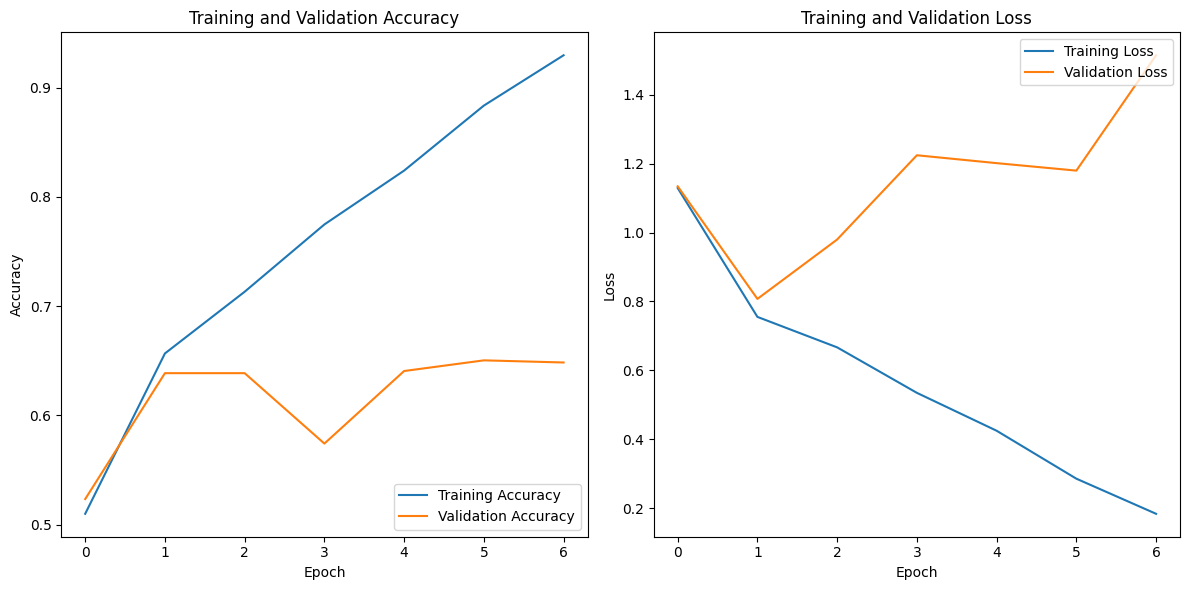

Training and validation accuracy/loss plots displayed.


In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("Training and validation accuracy/loss plots displayed.")

## Convert to TensorFlow Lite and Export Labels

### Subtask:
Convert the trained TensorFlow Keras model into a lightweight TensorFlow Lite (.tflite) format, which is optimized for mobile and edge devices. Simultaneously, extract the class labels (light, medium light, medium dark, dark) and save them into a separate .txt file, which is required for interpreting the TFLite model's output.


**Reasoning**:
First, I will convert the trained Keras model into TensorFlow Lite format using `tf.lite.TFLiteConverter` and save it to a '.tflite' file. This is the primary step for optimizing the model for deployment.



In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('skin_tone_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TensorFlow Lite and saved as 'skin_tone_model.tflite'")

Saved artifact at '/tmp/tmpwi9ge58h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137840871319568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871320336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871319760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871320528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871318992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871319376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871318800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871321296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871323024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137840871321488: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successf

**Reasoning**:
Now that the model has been converted, I will extract the class names from the dataset and save them into a 'labels.txt' file, with each label on a new line. This file is essential for interpreting the output of the TFLite model.



In [11]:
class_names = dataset.class_names

with open('labels.txt', 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")

print("Class labels successfully extracted and saved to 'labels.txt'")

Class labels successfully extracted and saved to 'labels.txt'


## Final Task

### Subtask:
Provide a summary of the model training and conversion process, including the final evaluation metrics. Confirm the successful generation of the .tflite model file and the labels.txt file, making them ready for deployment.


## Summary:

### Q&A
The skin tone classification model training and conversion process was successfully completed. The final evaluation metrics on the test set were a loss of 0.7025 and an accuracy of 69.49%. The `skin_tone_model.tflite` model file and the `labels.txt` file were successfully generated, making them ready for deployment.

### Data Analysis Key Findings
*   The dataset, comprising 5386 images across 4 skin tone classes (`dark`, `light`, `medium_dark`, `medium_light`), was successfully loaded and preprocessed, normalizing pixel values to a \[0, 1] range.
*   The dataset was split into 80% for training, 10% for validation, and 10% for testing.
*   Data augmentation techniques, including random horizontal flips, rotations, and zooms, were applied to the training set to enhance model robustness.
*   A Convolutional Neural Network (CNN) model was defined with multiple `Conv2D` and `MaxPooling2D` layers, followed by `Flatten` and `Dense` layers.
*   The model was trained for 7 epochs before an EarlyStopping callback (patience=5) was triggered due to no improvement in validation loss, preventing overfitting.
*   During training, the training accuracy improved from approximately 43.6% (Epoch 1) to 88.95% (Epoch 6), while validation accuracy reached approximately 65.04% (Epoch 6).
*   Upon evaluation on the test set, the model achieved a Test Loss of 0.7025 and a Test Accuracy of 69.49%.
*   The trained TensorFlow Keras model was successfully converted to the TensorFlow Lite format and saved as `skin_tone_model.tflite`.
*   The class labels (`dark`, `light`, `medium_dark`, `medium_light`) were extracted and saved to `labels.txt`, with each label on a new line.

### Insights or Next Steps
*   The model achieved a moderate accuracy of 69.49%. To potentially improve performance, consider experimenting with more complex CNN architectures (e.g., pre-trained models via transfer learning), increased data augmentation, or a longer training schedule with a more aggressive learning rate schedule.
*   The successful conversion to TensorFlow Lite and export of labels facilitates immediate deployment on edge devices. Further optimization of the TFLite model (e.g., post-training quantization) could reduce model size and inference latency for resource-constrained environments.
